# 分割嵌套的 dominator

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

构建计算图：

In [3]:
# Classic Diamond
def classic_diamond(inp, weight):
    conv2d = relay.op.nn.conv2d(inp, weight)
    relu = relay.op.nn.relu(conv2d)
    relu = relay.op.nn.relu(relu)
    leaky_relu = relay.op.nn.leaky_relu(conv2d, alpha=0)
    return relu + leaky_relu

# Deeper Branch
def deeper_diamond(inp, weight):
    conv2d = relay.op.nn.conv2d(inp, weight)
    relu = relay.op.nn.relu(conv2d)
    relu = relay.op.nn.relu(relu)
    relu = relay.op.tanh(relu)
    leaky_relu = relay.op.nn.leaky_relu(conv2d, alpha=0)
    return relu + leaky_relu

# Single Branch
def single_branch(inp, weight):
    conv2d = relay.op.nn.conv2d(inp, weight)
    relu = relay.op.nn.relu(conv2d)
    relu = relay.op.nn.relu(relu)
    tanh = relay.op.tanh(relu)
    return relu + tanh

# Fuzzy path/nested Diamond
def nested_diamond(inp, weight):
    conv2d = relay.op.nn.conv2d(inp, weight)
    relu = relay.op.nn.relu(conv2d)
    relu = relu + relu
    tanh = relay.op.tanh(relu)
    leaky_relu = relay.op.nn.leaky_relu(conv2d, alpha=0)
    return tanh + leaky_relu

In [4]:
inp = relay.var("input")
weight = relay.var("weight")
out = nested_diamond(
    single_branch(deeper_diamond(classic_diamond(inp, weight), weight), weight), weight
)

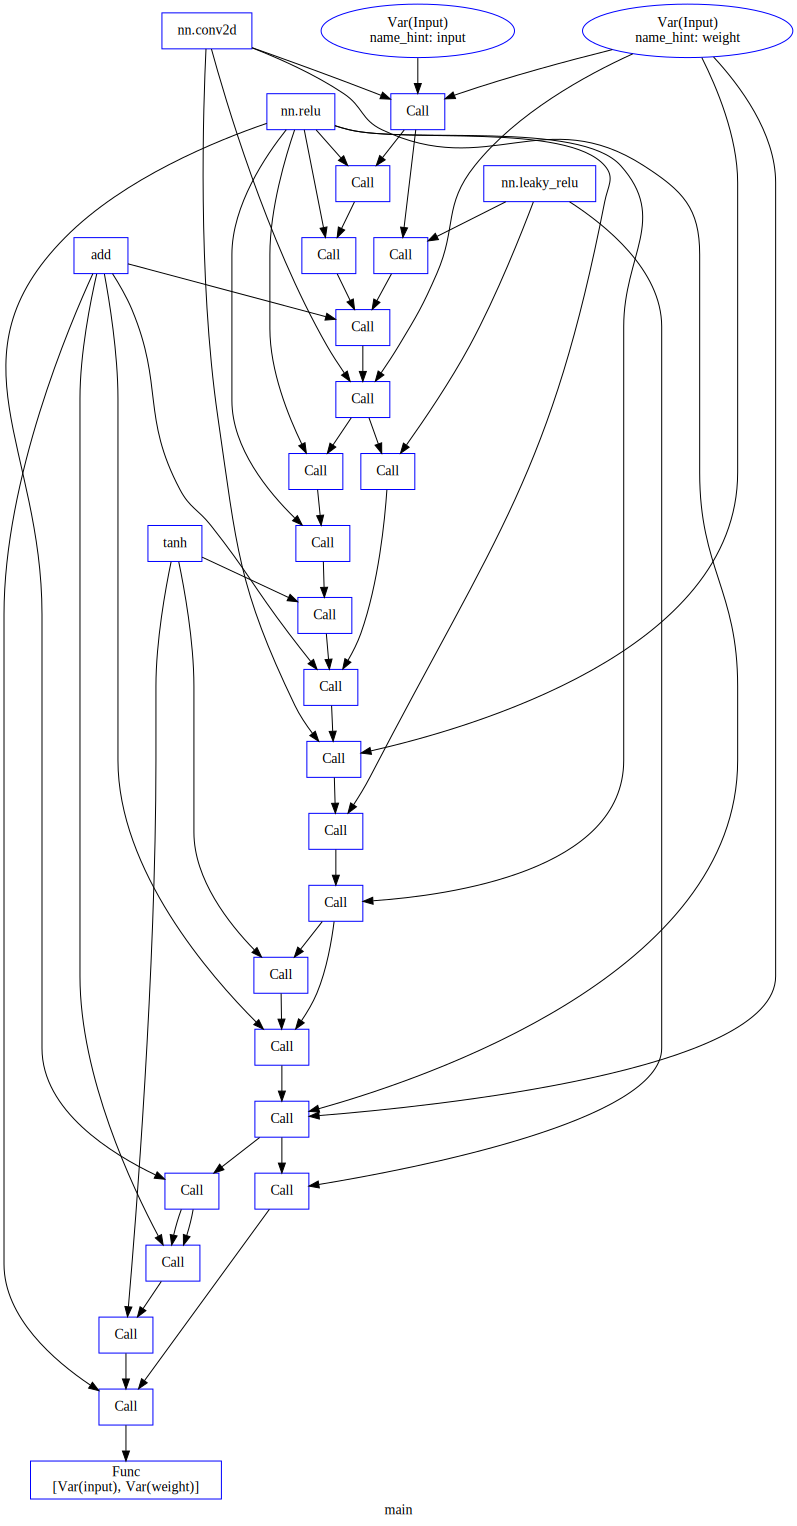

In [5]:
viz_expr(out)

In [6]:
print(tvm.IRModule.from_expr(out))

def @main(%input, %weight) {
  %0 = nn.conv2d(%input, %weight, padding=[0, 0, 0, 0]);
  %1 = nn.relu(%0);
  %2 = nn.relu(%1);
  %3 = nn.leaky_relu(%0, alpha=0f);
  %4 = add(%2, %3);
  %5 = nn.conv2d(%4, %weight, padding=[0, 0, 0, 0]);
  %6 = nn.relu(%5);
  %7 = nn.relu(%6);
  %8 = tanh(%7);
  %9 = nn.leaky_relu(%5, alpha=0f);
  %10 = add(%8, %9);
  %11 = nn.conv2d(%10, %weight, padding=[0, 0, 0, 0]);
  %12 = nn.relu(%11);
  %13 = nn.relu(%12);
  %14 = tanh(%13);
  %15 = add(%13, %14);
  %16 = nn.conv2d(%15, %weight, padding=[0, 0, 0, 0]);
  %17 = nn.relu(%16);
  %18 = add(%17, %17);
  %19 = tanh(%18);
  %20 = nn.leaky_relu(%16, alpha=0f);
  add(%19, %20)
}



构建模式：

In [7]:
# NB: 1 corresponds to the C++ enum that specicfies this
# we loose the type safety due to the Python/C++ calling
# convention.
K_ELEMWISE = 0
K_BROADCAST = 1

# Pattern
is_conv2d = is_op("nn.conv2d")(wildcard(), wildcard())
is_unary_elemwise = (wildcard().has_attr({"TOpPattern": K_ELEMWISE}))(wildcard()) | is_op(
    "add"
)(wildcard(), wildcard())
reduction = is_op("add")(wildcard(), wildcard())
diamond = dominates(is_conv2d, is_unary_elemwise, reduction)

分割计算图：

In [8]:
partitioned = diamond.partition(out)

In [9]:
print(tvm.IRModule.from_expr(partitioned))

def @main(%input, %weight) {
  %18 = fn (%FunctionVar_3_0, %FunctionVar_3_1, PartitionedFromPattern="nn.conv2d_nn.relu_nn.relu_nn.leaky_relu_add_") {
    %14 = nn.conv2d(%FunctionVar_3_0, %FunctionVar_3_1, padding=[0, 0, 0, 0]);
    %15 = nn.relu(%14);
    %16 = nn.relu(%15);
    %17 = nn.leaky_relu(%14, alpha=0f);
    add(%16, %17)
  };
  %19 = %18(%input, %weight);
  %20 = fn (%FunctionVar_2_0, %FunctionVar_2_1, PartitionedFromPattern="nn.conv2d_nn.relu_nn.relu_tanh_nn.leaky_relu_add_") {
    %9 = nn.conv2d(%FunctionVar_2_0, %FunctionVar_2_1, padding=[0, 0, 0, 0]);
    %10 = nn.relu(%9);
    %11 = nn.relu(%10);
    %12 = tanh(%11);
    %13 = nn.leaky_relu(%9, alpha=0f);
    add(%12, %13)
  };
  %21 = %20(%19, %weight);
  %22 = fn (%FunctionVar_1_0, %FunctionVar_1_1, PartitionedFromPattern="nn.conv2d_nn.relu_nn.relu_tanh_add_") {
    %5 = nn.conv2d(%FunctionVar_1_0, %FunctionVar_1_1, padding=[0, 0, 0, 0]);
    %6 = nn.relu(%5);
    %7 = nn.relu(%6);
    %8 = tanh(%7);
    add(%7, %8)
